In [ ]:
# !rm -r sample_data .config
# !git clone https://github.com/saveliybabin/VRP-solver .

In [1144]:
#!g1.1
import requests
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from train import train_epoch_sl
from nets.nar_model_vrp import NARModel
from nets.encoders.gnn_encoder import GNNEncoder
from utils import torch_load_cpu, load_problem
import warnings
warnings.filterwarnings('ignore')

In [1145]:
#!g1.1
%pip install pickle5
import pickle5 as pickle

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1146]:
#!g1.1
%pip install ortools

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1147]:
#!g1.1
problem = load_problem('cvrp')

In [1052]:
#!g1.1
# import zipfile
# zf = zipfile.ZipFile('data/preprocessing_data/train_50_sol.zip', 'r')
# f = zf.open('train_50_sol.pkl')

In [1053]:
#!g1.1
# train_dataset = pickle.load(f)

In [1148]:
#!g1.1
import pickle
with open('data/preprocessing_data/train_20_sol.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('data/preprocessing_data/val_20_sol.pkl', 'rb') as f:
    val_dataset = pickle.load(f)    
    

In [1076]:
#!g1.1
val_dataset[0]['demand']

tensor([0.2333, 0.1333, 0.0667, 0.3000, 0.1667, 0.1000, 0.3000, 0.0333, 0.1667,
        0.0333, 0.2333, 0.1333, 0.2000, 0.0333, 0.3000, 0.1667, 0.2000, 0.1333,
        0.1667, 0.1333])

In [1055]:
# train_dataset = problem.make_dataset(
#         'data/vrp/dataset_test.pkl', size=21, num_samples=12800
#     )


In [1056]:
# import pickle
# def save_object(obj, filename):
#     with open(filename, 'wb') as outp:  # Overwrites any existing file.
#         pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# # sample usage
# save_object(train_dataset, 'train_cvrp_v3_12800.pkl')

In [1057]:
# val_dataset = problem.make_dataset(
#         'data/vrp/dataset_test_2.pkl', size=21, num_samples=1000
#     )

In [1058]:
# save_object(val_dataset, 'val_cvrp_v5_1000.pkl')

In [975]:
#!g1.1
train_dataset[1]['graph'][0, :].

tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
       dtype=torch.uint8)

In [978]:
#!g1.1
train_dataset[1]['tour_nodes']

tensor([ 0.,  0.,  1., 15., 19., 11.,  8.,  0., 10.,  3.,  2.,  0., 20., 16.,
         9.,  7.,  4.,  6., 18.,  0.,  5., 12., 13., 17., 14.,  0.])

In [504]:
train_example = train_dataset[1]
train_example['demand'].shape

torch.Size([20])

In [505]:
len(train_example['tour_nodes'])

26

In [506]:
def edges(adj):

    for i, neighbors in enumerate(adj):
        for j, v in enumerate(neighbors):
            if v:
                yield (i, j)

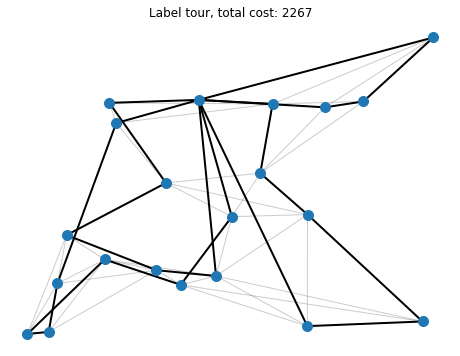

In [507]:
all_loc = np.concatenate((np.array(train_example['depot']).reshape(1, -1), np.array(train_example['loc'])), 0)
dist_matrix = squareform(pdist(all_loc))
G = nx.from_numpy_array(1-train_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord for i, coord in enumerate(all_loc)}
# tour = train_example['tour_edges'].nonzero().numpy()
tour = [i for i in edges(train_example['adj'])]
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=tour, )
# tour = train_example['tour_nodes'].numpy()
# tour = np.append(tour, tour[0])
cost = train_example['total_dist']
plt.title(f'Label tour, total cost: {cost:.0f}')
plt.axis('off')
plt.show()

In [1059]:
#!g1.1
from nets.attention_model import AttentionModel
model = AttentionModel(
    problem=load_problem('cvrp'),
    embedding_dim=100,
    encoder_class=GNNEncoder,
    n_encode_layers=3,
    aggregation='max',
    aggregation_graph='mean',
    normalization='batch',
    n_heads = 4,
    decode_type = "greedy",
    graph_mask = True
)
# model = pickle.load(open('/content/trained_models/vrp_solver1.sav', 'rb'))
model.to('cuda')

AttentionModel(
  (init_embed_depot): Linear(in_features=2, out_features=100, bias=True)
  (init_embed): Linear(in_features=3, out_features=100, bias=True)
  (embedder): GNNEncoder(
    (init_embed_edges): Embedding(3, 100)
    (layers): ModuleList(
      (0): GNNLayer(
        (U): Linear(in_features=100, out_features=100, bias=True)
        (V): Linear(in_features=100, out_features=100, bias=True)
        (A): Linear(in_features=100, out_features=100, bias=True)
        (B): Linear(in_features=100, out_features=100, bias=True)
        (C): Linear(in_features=100, out_features=100, bias=True)
        (norm_h): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm_e): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (1): GNNLayer(
        (U): Linear(in_features=100, out_features=100, bias=True)
        (V): Linear(in_features=100, out_features=100, bias=True)
        (A): Linear(in_features=100, o

In [1060]:
#!g1.1

optimizer = optim.Adam(params=model.parameters(), lr=0.0005)

In [1061]:
#!g1.1
import warnings
warnings.filterwarnings("ignore")
class option():
    def __init__(self):
        self.run_name = 'train'
        self.epoch_size = 10000
        self.batch_size = 100
        self.no_tensorboard = True
        self.num_workers = 0
        self.no_progress_bar = False
        self.device = 'cuda'
        self.model = 'ar'
        self.accumulation_steps = 8
        self.max_grad_norm = 1
        self.log_step = 100
        self.checkpoint_epochs = 0
        self.n_epochs = 20
        self.save_dir = ""
opt = option()

for epoch in range(opt.n_epochs):
    train_epoch_sl(
        model,
        optimizer,
        optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1.0 ** epoch),
        epoch,
        train_dataset,
        [val_dataset],
        problem,
        None,
        opt
    )

KeyboardInterrupt: 


Start train epoch 0, lr=0.0005 for run train

epoch: 0, train_batch_id: 0, loss: 39008640.0, avg_cost: 13.60013198852539
grad_norm: 7.215588569641113, clipped: 1

Start train epoch 0, lr=0.0005 for run train

epoch: 0, train_batch_id: 0, loss: 38146572.0, avg_cost: 13.6658296585083
grad_norm: 6.331782817840576, clipped: 1
Finished epoch 0, took 00:00:41 s
Validation groundtruth cost: 15.116 +- 1.247
Validation average cost: 23.220 +- 2.923
Validation optimality gap: 53.790% +- 16.390

Start train epoch 1, lr=0.0005 for run train

epoch: 1, train_batch_id: 0, loss: 39439676.0, avg_cost: 13.826236724853516
grad_norm: 1.5063291788101196, clipped: 1
Finished epoch 1, took 00:00:41 s
Validation groundtruth cost: 15.116 +- 1.247
Validation average cost: 22.288 +- 2.841
Validation optimality gap: 47.552% +- 15.300

Start train epoch 2, lr=0.0005 for run train

epoch: 2, train_batch_id: 0, loss: 38362092.0, avg_cost: 13.578888893127441
grad_norm: 0.9387574195861816, clipped: 0.938757419586181


 78%|#######8  | 78/100 [00:32<00:09,  2.38it/s]


KeyboardInterrupt: 

In [563]:
#!g1.1

# import warnings
# warnings.filterwarnings("ignore")
# class option():
#     def __init__(self):
#         self.run_name = 'train'
#         self.epoch_size = 10000
#         self.batch_size = 100
#         self.no_tensorboard = True
#         self.num_workers = 0
#         self.no_progress_bar = False
#         self.device = 'cuda'
#         self.model = 'ar'
#         self.accumulation_steps = 8
#         self.max_grad_norm = 1
#         self.log_step = 100
#         self.checkpoint_epochs = 0
#         self.n_epochs = 50
#         self.save_dir = ""
# opt = option()

# for epoch in range(opt.n_epochs):
#     train_epoch_sl(
#         model,
#         optimizer,
#         optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1.0 ** epoch),
#         epoch,
#         train_dataset,
#         [val_dataset],
#         problem,
#         None,
#         opt
#     )

100%|██████████| 10/10 [00:43<00:00,  4.35s/it]



Start train epoch 0, lr=0.0005 for run train

epoch: 0, train_batch_id: 0, loss: 47395856.0, avg_cost: 6.596263408660889
grad_norm: 1.5415818691253662, clipped: 1
Finished epoch 0, took 00:00:14 s
Validation groundtruth cost: 7.623 +- 0.853
Validation average cost: 10.140 +- 1.439
Validation optimality gap: 33.446% +- 15.992

Start train epoch 1, lr=0.0005 for run train

epoch: 1, train_batch_id: 0, loss: 42187520.0, avg_cost: 6.889687538146973
grad_norm: 0.007819592021405697, clipped: 0.007819592021405697
Finished epoch 1, took 00:00:14 s
Validation groundtruth cost: 7.623 +- 0.853
Validation average cost: 10.577 +- 1.487
Validation optimality gap: 39.248% +- 16.980

Start train epoch 2, lr=0.0005 for run train

epoch: 2, train_batch_id: 0, loss: 50520860.0, avg_cost: 6.775096893310547
grad_norm: 0.1288904994726181, clipped: 0.1288904994726181
Finished epoch 2, took 00:00:15 s
Validation groundtruth cost: 7.623 +- 0.853
Validation average cost: 9.562 +- 1.401
Validation optimality ga

In [463]:
#!g1.1
[33.718, 29.612, 28.962, 21.877, 18.778, 17.991, 15.944, 14.952, 15.066, 14.764, 13.336, 12.331, 13.484, 13.667, 12.542, 13.469, 13.305, 11.651, 12.880, 13.848, 13.813, 12.818, 12.179, 13.162, 11.912, 12.766, 12.264, 11.805, 12.731, 13.123]

[33.718,
 29.612,
 28.962,
 21.877,
 18.778,
 17.991,
 15.944,
 14.952,
 15.066,
 14.764,
 13.336,
 12.331,
 13.484,
 13.667,
 12.542,
 13.469,
 13.305,
 11.651,
 12.88,
 13.848,
 13.813,
 12.818,
 12.179,
 13.162,
 11.912,
 12.766,
 12.264,
 11.805,
 12.731,
 13.123]

In [769]:
#!g1.1
# import pickle

# filename = 'model_AR_50ep_3enc.sav'
# pickle.dump(model, open(filename, 'wb'))

In [1062]:
#!g1.1
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# sample usage
save_object(model, 'model_AR_50n_2ep_3enc.sav')

In [770]:
#!g1.1
from torch.utils.data import DataLoader, RandomSampler
loader = DataLoader(val_dataset, batch_size=opt.batch_size, shuffle=False, num_workers=opt.num_workers)

In [771]:
#!g1.1
for i, bat in enumerate(loader):
    if i == 0:
        break

In [772]:
#!g1.1
opts = opt

In [904]:
#!g1.1
from utils.functions import move_to

add_depot_demand = torch.cat((torch.zeros([bat['demand'].size()[0], 1]), bat['demand']), 1)
add_depot_loc = torch.cat((bat['depot'][:, None], bat['loc']), 1)
pre_x = torch.cat((add_depot_loc, add_depot_demand[:, :, None]), 2)
if opts.model == 'nar':
    x = move_to(pre_x, opts.device)
else:
    x = move_to(bat, opts.device)
car_num = (bat['tour_nodes'][0] == 0).sum().item() - 1

#             all_loc = np.concatenate((np.array(bat['depot']).reshape(1, -1), np.array(bat['loc'])), 0)
#             bat_all = torch.tensor(np.concatenate((all_loc, all_demand), 1), dtype=torch.float)
# cost, _ = model(move_to(x, opts.device), move_to(bat['graph'].type(torch.int64), opts.device), car_num)

In [905]:
#!g1.1
nodes = x

In [906]:
#!g1.1
graph = bat['graph'].to('cuda')

In [907]:
#!g1.1
with torch.no_grad():
    model.decode_type = 'greedy'
    cost, loss, tour = model.forward(nodes, graph, car_num, return_pi=True)
tour = tour.cpu().numpy()
# tour = np.append(tour, tour[0])

In [908]:
#!g1.1
import warnings
warnings.filterwarnings("ignore")
costs_true = []
costs_predict = []
from tqdm.auto import tqdm
from generator.distance_matrix import distance_function
customer_count = 21
for i in tqdm(range(28)):
    loc_tensor = torch.cat((bat['depot'][i][None, :], bat['loc'][i]), 0)
    distance = distance_function(loc_tensor, is_coord = False)
    dist_matrix =pd.DataFrame(distance)
    dist_matrix.iloc[range(customer_count), range(customer_count)] = 0
    dist_matrix = dist_matrix.values
    cost = dist_matrix[bat['tour_nodes'][i][:-1].cpu().numpy().astype(int), bat['tour_nodes'][i][1:].cpu().numpy().astype(int)].sum()
    costs_true.append(cost)
    tour_upd = torch.cat((torch.zeros(1), torch.tensor(tour[i]))).type(torch.int64)
    tour_upd = torch.cat((torch.tensor(tour_upd), torch.zeros(1))).type(torch.int64)
    cost = dist_matrix[tour_upd[:-1], tour_upd[1:]].sum()
    costs_predict.append(cost)

In [1206]:
#!g1.1
cvrplib = False

In [1248]:
#!g1.1
if cvrplib:
    from generator.parse_cvrplib import get_instance_from_CVRPLIB
    from problems.vrp.problem_vrp import nearest_neighbor_graph

    car_num = 7
    test_df, test_tour, test_paths  = get_instance_from_CVRPLIB("A", "A-n46-k7")
    test_df['demand_norm'] = test_df['demand']/test_df['cap']
    test_df['latitude_norm'] = test_df['latitude']/100
    test_df['longitude_norm'] = test_df['longitude']/100
    x = torch.tensor(test_df[['latitude_norm', 'longitude_norm']].values).type(torch.float)
    df_x = torch.tensor(test_df[['latitude_norm', 'longitude_norm', 'demand_norm']].values).type(torch.float).to('cuda')
    graph = torch.ByteTensor(nearest_neighbor_graph(x, neighbors = 0.2, knn_strat = 'percentage')).to('cuda') 

else:
    car_num = 5
    test_example = val_dataset[84]
    with torch.no_grad():
        add_depot_demand = torch.cat((torch.zeros(1), test_example['demand']), 0)
        add_depot_loc = torch.cat((test_example['depot'][None, :], test_example['loc']), 0)
        df_x = torch.cat((add_depot_loc, add_depot_demand[:, None]), 1).to('cuda')
        x = test_example
        graph = test_example['graph'].to('cuda')

In [1249]:
#!g1.1
dist_matrix = squareform(pdist(df_x[:, :2].cpu().numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = 0

Make GNN prediction

In [1250]:
#!g1.1
#nodes = {'loc': df_x[1:, :2][None, :], 'demand' : df_x[1:, 2:].flatten()[None, :], 'depot': df_x[:1, :2]}
nodes = df_x[None, ...].to('cuda')
graph_ = graph[None, ...].to('cuda')
# model.eval()
# with torch.no_grad():
#     embeddings = model.embedder(model._init_embed(nodes), graph_)
# embeddings.shape

In [ ]:
# with torch.no_grad():
#     Ux = model.project_node_emb(embeddings)
#     Gx = model.project_graph_emb(embeddings.mean(dim=1))
# edge_embeddings = F.relu(Ux[:, :, None, :] + Ux[:, None, :, :] + Gx[:, None, None, :])

# if model.mask_graph:
#     edge_embeddings[graph[:, :, :, None].expand_as(edge_embeddings)] = 0

# # Compute logits
# with torch.no_grad():
#     logits = model.edge_pred(edge_embeddings)  # B x V x V x 2
# proba = F.softmax(logits, dim=3)
# proba_adj = proba[0, :, :, 1].cpu().numpy()
# proba_adj.shape

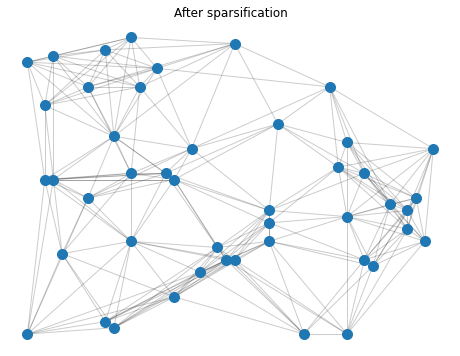

In [592]:
#!g1.1
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.cpu().numpy() for i, coord in enumerate(torch.cat((nodes['depot'], nodes['loc'].squeeze(0)), 0))}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
plt.title('After sparsification')
plt.axis('off')
plt.show()

In [ ]:
# G = nx.from_numpy_array(proba_adj)
# G.remove_edges_from(nx.selfloop_edges(G))
# pos = {i: coord.numpy() for i, coord in enumerate(torch.cat((x['depot'][None, :], x['loc'][:, :2]), 0))}
# plt.figure(figsize=(8, 6))
# nx.draw_networkx_nodes(G, pos=pos, node_size=100)
# nx.draw_networkx_edges(G, pos=pos, width=[(G[u][v]['weight']*2)**2 for u,v in G.edges])
# plt.title('Probabilistic graph')
# plt.axis('off')
# plt.show()

GNN model

In [1251]:
#!g1.1
def array_separator(arr):
  out = []
  out_temp = [0]
  for i in arr[1:]:
    if i == 0:
      if len(out_temp) != 1:
        out_temp.append(0)
        out.append(np.array(out_temp))
      out_temp = [0]
    else:
      out_temp.append(i)
  return np.array(out)

In [1252]:
#!g1.1
with torch.no_grad():
    model.decode_type = 'greedy'
    _, _, tour = model.forward(nodes, graph_, car_num, return_pi=True)
tour = tour.cpu().numpy()[0]
tour = np.append(tour, tour[0])

In [1253]:
#!g1.1
len(tour)

26

In [1223]:
#!g1.1
tour = torch.cat((torch.zeros(1), torch.tensor(tour))).type(torch.int64)
while len(tour) != 26:
    tour = torch.cat((torch.tensor(tour), torch.zeros(1))).type(torch.int64)

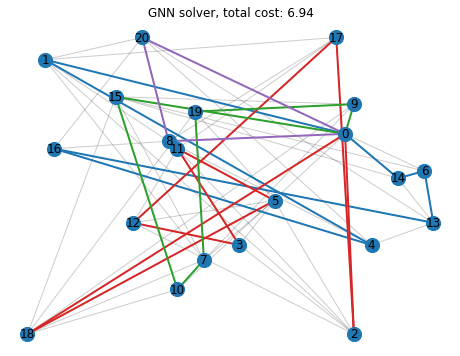

In [1254]:
#!g1.1
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1).tolist(), edge_color = colors[n])
nx.draw_networkx_labels(G, pos)
dist_matrix_ = dist_matrix.copy()
dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
cost = dist_matrix_[tour[:-1], tour[1:]].sum()
plt.title(f'GNN solver, total cost: {cost:.2f}')
plt.axis('off')
plt.show()


In [1257]:
#!g1.1
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in tour[1:]:
      if i.item() == 0:
          car+=1
      else:
          temp[car] += test_df['demand'][i.item()]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in tour[1:]:
      if i == 0:
          car+=1
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: 0, 1: tensor(1.), 2: tensor(1.), 3: tensor(0.9667), 4: tensor(0.5333)}

OR-Tools

In [1258]:
#!g1.1
if cvrplib:
  from heurictics.op_tools import *
  from generator.distance_matrix import distance_function
  customer_count = 45+1

  distance = distance_function(test_df[['latitude', 'longitude']].values, is_coord = False)
  dist_matrix =pd.DataFrame(distance)
  dist_matrix.iloc[range(customer_count), range(customer_count)] = 0

  op_results = main(test_df, distance, cars = test_df['cars'].max(), cap = test_df['cap'].max())
  tour_sublist = np.array(list(op_results['paths'].values()))
  rtour = np.array([item for sublist in tour_sublist for item in sublist])
else:
  rtour = test_example['tour_nodes'].numpy()

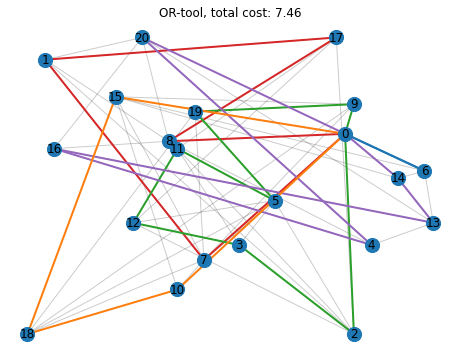

In [1259]:
#!g1.1
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(rtour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1).tolist(), edge_color = colors[n])
nx.draw_networkx_labels(G,pos)
cost = dist_matrix_[rtour[:-1].astype(int), rtour[1:].astype(int)].sum()
plt.title(f'OR-tool, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

In [1260]:
#!g1.1
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in rtour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in rtour[1:].astype(int):
      if i == 0:
          car+=1
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: tensor(0.1667),
 1: tensor(1.),
 2: tensor(0.8667),
 3: tensor(0.9667),
 4: tensor(0.5000)}

Greedy solution

In [1087]:
# #!g1.1
# from generator.distance_matrix import distance_function
# from heurictics.greedy import greedy_heurictics
# from tqdm.auto import tqdm

# car_num = 5
# cost_arr = []
# for i in tqdm(range(1000)):
#     test_example = val_dataset[i]
#     with torch.no_grad():
#         add_depot_demand = torch.cat((torch.zeros(1), test_example['demand']), 0)
#         add_depot_loc = torch.cat((test_example['depot'][None, :], test_example['loc']), 0)
#         df_x = torch.cat((add_depot_loc, add_depot_demand[:, None]), 1).to('cuda')
#         x = test_example
#         graph = test_example['graph'].to('cuda')
#         test_df_ = pd.DataFrame(torch.cat((test_example['depot'][None, : ], test_example['loc']), 0).numpy(), columns = ['latitude', 'longitude'])
#         test_df_['demand'] = torch.cat((torch.zeros(1), test_example['demand']), 0).numpy()
#         df_gr = test_df_.copy()
#         df_gr['cap'] = 1 

#         customer_count = 21
#         distance = distance_function(df_gr[['latitude', 'longitude']].values, is_coord = False)
#         dist_matrix =pd.DataFrame(distance)
#         dist_matrix.iloc[range(customer_count), range(customer_count)] = np.inf
#         greedy_results = greedy_heurictics(df_gr, dist_matrix, dim = customer_count, cap = df_gr['cap'].max(), k_nei = 18, iters = 10)
#         gr_tour = []
#         for p in greedy_results['paths'].values():
#             for node in p: 
#                 gr_tour.append(node)
#         gr_tour = np.array(gr_tour)
#         cost = dist_matrix_[gr_tour[:-1].astype(int), gr_tour[1:].astype(int)].sum()
#         cost_arr.append(cost)
        
# np.mean(cost_arr)/7.623, np.std(cost_arr)

In [1261]:
#!g1.1
if not cvrplib:
    test_df_ = pd.DataFrame(torch.cat((test_example['depot'][None, : ], test_example['loc']), 0).numpy(), columns = ['latitude', 'longitude'])
    test_df_['demand'] = torch.cat((torch.zeros(1), test_example['demand']), 0).numpy()
    df_gr = test_df_.copy()
    df_gr['cap'] = 1
else:
  df_gr = test_df.copy()

In [1263]:
#!g1.1
from generator.distance_matrix import distance_function
customer_count = 21

distance = distance_function(df_gr[['latitude', 'longitude']].values, is_coord = False)
dist_matrix =pd.DataFrame(distance)
dist_matrix.iloc[range(customer_count), range(customer_count)] = np.inf

In [1265]:
#!g1.1
from heurictics.greedy import greedy_heurictics

greedy_results = greedy_heurictics(df_gr, dist_matrix, dim = customer_count, cap = df_gr['cap'].max(), k_nei = 17, iters = 100)

In [1266]:
#!g1.1
gr_tour = []
for p in greedy_results['paths'].values():
  for node in p: 
    gr_tour.append(node)

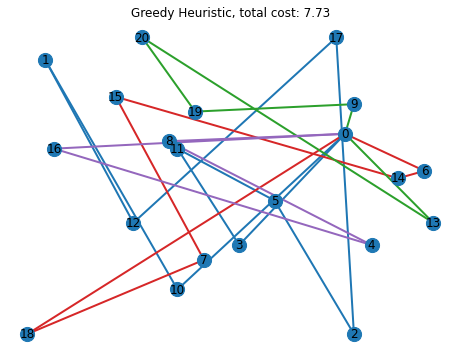

In [1267]:
#!g1.1
gr_tour = np.array(gr_tour)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(gr_tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1).tolist(), edge_color = colors[n])
nx.draw_networkx_labels(G,pos)
cost = dist_matrix_[gr_tour[:-1].astype(int), gr_tour[1:].astype(int)].sum()
plt.title(f'Greedy Heuristic, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

Exact solution from CVRPLib (if exists)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from typing import Optional, Dict, Set, Iterator, Callable, cast


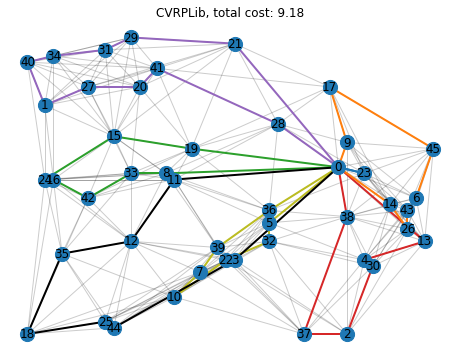

In [613]:
#!g1.1
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(test_tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1).tolist(), edge_color = colors[n])
nx.draw_networkx_labels(G, pos)
dist_matrix = squareform(pdist(x[:, :2].numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf
dist_matrix_ = dist_matrix.copy()
dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
cost = dist_matrix_[test_tour[:-1], test_tour[1:]].sum()
plt.title(f'CVRPLib, total cost: {cost:.2f}')
plt.axis('off')
plt.show()


In [614]:
#!g1.1
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in test_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in test_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: 0.18,
 1: 0.9500000000000001,
 2: 0.99,
 3: 1.0000000000000002,
 4: 1.0,
 5: 0.91,
 6: 1.0}

In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [1236]:
#!g1.1
model = pickle.load(open('model_NAR_30ep_1beam_4enc.sav', 'rb'))

In [1150]:
#!g1.1
#!g1.1
def array_separator(arr):
  out = []
  out_temp = [0]
  for i in arr[1:]:
    if i == 0:
      if len(out_temp) != 1:
        out_temp.append(0)
        out.append(np.array(out_temp))
      out_temp = [0]
    else:
      out_temp.append(i)
  return np.array(out)

In [1238]:
#!g1.1
df_x

tensor([[0.0675, 0.3349, 0.0000],
        [0.0338, 0.2550, 0.2333],
        [0.7626, 0.4111, 0.1333],
        [0.2243, 0.8534, 0.0667],
        [0.4567, 0.4262, 0.3000],
        [0.7736, 0.0056, 0.1667],
        [0.9349, 0.5671, 0.1000],
        [0.2088, 0.3789, 0.3000],
        [0.5711, 0.0802, 0.0333],
        [0.6336, 0.5439, 0.1667],
        [0.7772, 0.2675, 0.0333],
        [0.8103, 0.0199, 0.2333],
        [0.1606, 0.3858, 0.1333],
        [0.5641, 0.4523, 0.2000],
        [0.1120, 0.7184, 0.0333],
        [0.6209, 0.2894, 0.3000],
        [0.0278, 0.0094, 0.1667],
        [0.8910, 0.3227, 0.2000],
        [0.5325, 0.6494, 0.1333],
        [0.7816, 0.8653, 0.1667],
        [0.7613, 0.9968, 0.1333]], device='cuda:0')

In [1245]:
#!g1.1
cost_true_dict = {}
cost_dict = {}
for per in [0.2]:#, 0.3, 0.4, 0.5, 0.7]:
    cost_arr = []
    cost_true_arr = []
    car_num = 5
    for i in tqdm(range(100)):
        test_example = val_dataset[i]
        with torch.no_grad():
            add_depot_demand = torch.cat((torch.zeros(1), test_example['demand']), 0)
            add_depot_loc = torch.cat((test_example['depot'][None, :], test_example['loc']), 0)
            df_x = torch.cat((add_depot_loc, add_depot_demand[:, None]), 1).to('cuda')
            x = test_example
            dist_matrix = squareform(pdist(df_x[:, :2].cpu().numpy()))
            dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = 0
            graph = torch.tensor(nearest_neighbor_graph(df_x[:, :2].cpu(), neighbors = per, knn_strat = 'percentage')).type(torch.uint8).to('cuda')
    #         graph = test_example['graph'].to('cuda')
            nodes = {'loc': df_x[1:, :2][None, :], 'demand' : df_x[1:, 2:].flatten()[None, :], 'depot': df_x[:1, :2]}
            graph_ = graph[None, ...]
            with torch.no_grad():
                model.decode_type = 'greedy'
                _, _, tour = model.forward(df_x[None, ...].to('cuda'), graph_, car_num, return_pi=True)
            tour = tour.cpu().numpy()[0]
            tour = np.append(tour, tour[0])
                
#             tour = torch.cat((torch.zeros(1).to('cuda'), torch.tensor(tour[0]))).type(torch.int64)
#             tour = torch.cat((torch.tensor(tour), torch.zeros(1).to('cuda'))).type(torch.int64)
#             tour = tour.cpu().numpy()
            dist_matrix_ = dist_matrix.copy()
            dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
            or_tour = test_example['tour_nodes'].cpu().numpy()
    #         test_df = pd.DataFrame(df_x, columns = ['latitude', 'longitude', 'demand'])
    #         test_df['cars'] = 5
    #         test_df['cap'] = 1
    #         op_results = main(test_df, dist_matrix, cars = test_df['cars'].max(), cap = test_df['cap'].max())
    #         tour_sublist = np.array(list(op_results['paths'].values()))
    #         or_tour = np.array([item for sublist in tour_sublist for item in sublist])
            cost = dist_matrix_[tour[:-1], tour[1:]].sum()
            cost_true =dist_matrix_[or_tour[:-1].astype(int), or_tour[1:].astype(int)].sum()
            cost_arr.append(cost)
            cost_true_arr.append(cost_true)
    cost_true_dict[per] = cost_true_arr
    cost_dict[per] = cost_arr

In [1246]:
#!g1.1
cost_arr_t = cost_dict[0.2]
cost_true_arr_t = cost_true_dict[0.2]
temp = pd.DataFrame([cost_arr_t, cost_true_arr_t]).T
temp[2] = temp[0]/temp[1]*100 - 100
temp[2].mean()

16.456941428852787

In [1247]:
#!g1.1
temp[temp[2]<0]

,0,1,2
6,7.469553,7.484747,-0.202998
11,5.591482,6.151538,-9.104333
14,5.472521,5.488372,-0.288809
26,5.725709,5.936475,-3.550353
63,5.329541,5.428497,-1.822901
75,6.490838,6.912548,-6.100649
84,6.940672,7.457067,-6.924902
95,6.149248,6.370208,-3.468647
97,6.131841,6.481134,-5.389384


In [1153]:
#!g1.1
test_example = val_dataset[0]
with torch.no_grad():
    add_depot_demand = torch.cat((torch.zeros(1), test_example['demand']), 0)
    add_depot_loc = torch.cat((test_example['depot'][None, :], test_example['loc']), 0)
    df_x = torch.cat((add_depot_loc, add_depot_demand[:, None]), 1).to('cuda')
    x = test_example
    dist_matrix = squareform(pdist(df_x[:, :2].cpu().numpy()))
    dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = 0

In [1162]:
#!g1.1
graph = torch.tensor(nearest_neighbor_graph(df_x[:, :2].cpu(), neighbors = .5, knn_strat = 'percentage')).type(torch.uint8).to('cuda')


In [1161]:
#!g1.1
graph

tensor([[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 

In [ ]:
#!g1.1


In [1159]:
#!g1.1
test_example['graph'].size()

torch.Size([21, 21])

In [1152]:
#!g1.1
graph = torch.tensor(nearest_neighbor_graph(df_x[:, :2].cpu(), neighbors = .5, knn_strat = 'percentage')).type(torch.int64)#.to('cuda')


NameError: name 'df_x' is not defined

In [ ]:
#!g1.1


In [1169]:
#!g1.1
temp = pd.DataFrame([cost_arr, cost_true_arr]).T
temp[2] = temp[0]/temp[1]*100 - 100
temp[2].mean()

12.171199802993112

In [1164]:
#!g1.1
temp = pd.DataFrame([cost_arr, cost_true_arr]).T
temp[2] = temp[0]/temp[1]*100 - 100
temp

,0,1,2
0,8.127896,6.757353,20.282237
1,6.935095,6.146232,12.834900
2,6.608460,6.012047,9.920290
3,9.171863,6.919487,32.551201
4,9.122822,8.923061,2.238712
5,8.270649,7.324737,12.913946
6,6.759147,7.484747,-9.694374
7,8.218431,7.366859,11.559495
8,5.998362,6.223341,-3.615078
9,7.833572,6.608375,18.540063


In [1166]:
#!g1.1
temp[2].mean()

10.753139191433753

In [1131]:
#!g1.1
or_tour = test_example['tour_nodes'].cpu().numpy()

In [1133]:
#!g1.1
dist_matrix_[or_tour[:-1].astype(int), or_tour[1:].astype(int)].sum()

6.60837547222193

In [ ]:
#!g1.1
